# Punto 3 – Modelado de Serie Diaria (Uso del Dinero)
**Modelo elegido:** SARIMA (statsmodels) con estacionalidad semanal `S=7`.

**Objetivo:** Entrenar con **jul–sep 2022**, validar en **oct 2022** (MAPE) y pronosticar **nov 2022**.

## 1. Imports y configuración de paths

Importa librerías necesarias (numpy, pandas, matplotlib, statsmodels, warnings) y configura rutas robustas para cargar los datos y guardar resultados.

In [5]:

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Detección robusta del ROOT del proyecto (soporta ejecutar desde modelos/ o raíz)
CANDIDATES = [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]
ROOT = None

RAW_CLEAN = "../data/clean/Punto3.SerieUsodeldinero_clean.csv"
OUT_DIR = "../modelos/outputs_p3/"

RAW_CLEAN

'../data/clean/Punto3.SerieUsodeldinero_clean.csv'

## 2. Carga y preparación de datos

Cargamos el archivo CSV limpio, convierte la columna de fechas, ordena y define la variable objetivo. Realiza el split en train (jul-sep 2022) y test (oct 2022).

In [7]:
# %% Cargar datos limpios
df = pd.read_csv(RAW_CLEAN, parse_dates=["fecha"])
df = df.sort_values("fecha").reset_index(drop=True)

# Serie principal (en millones)
y_col = "valor_total_millones"
df = df.set_index("fecha")

# Split
train = df.loc["2022-07-01":"2022-09-30", [y_col]].copy()
test_oct = df.loc["2022-10-01":"2022-10-31", [y_col]].copy()

train.shape, test_oct.shape, train.head(3), test_oct.head(3)

((92, 1),
 (31, 1),
             valor_total_millones
 fecha                           
 2022-07-01          55871.592578
 2022-07-02          10567.733300
 2022-07-03            104.749304,
             valor_total_millones
 fecha                           
 2022-10-01          12811.874289
 2022-10-02              0.000000
 2022-10-03          41584.688258)

## 3. Visualización de la serie diaria

Grafica la serie completa de julio a octubre 2022 para inspección visual de tendencias y estacionalidad. (Revisamos lo mismo que el EDA)

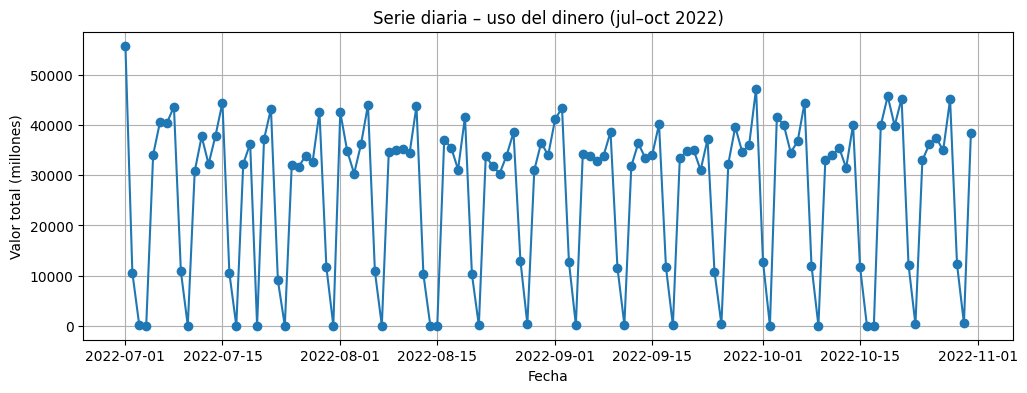

In [8]:
# %% Visual: serie completa (julio - octubre)
plt.figure(figsize=(12,4))
plt.plot(df.index, df[y_col], marker='o', linestyle='-')
plt.title("Serie diaria – uso del dinero (jul–oct 2022)")
plt.xlabel("Fecha")
plt.ylabel("Valor total (millones)")
plt.grid(True)
plt.show()

## 4. Grid search de hiperparámetros SARIMA

Realiza una búsqueda pequeña sobre los hiperparámetros (p,d,q,P,D,Q) de SARIMA con estacionalidad semanal S=7, seleccionando el modelo con menor AIC.

### Búsqueda (pequeña) de hiperparámetros SARIMA usando AIC

In [9]:
# %% Grid search básico de SARIMA con S=7
import math

best = {"aic": math.inf, "order": None, "seasonal_order": None, "res": None}

y_train = train[y_col]

for p in range(0,3):       # 0..2
    for d in range(0,2):   # 0..1
        for q in range(0,3):  # 0..2
            for P in range(0,2):  # 0..1
                for D in range(0,2):  # 0..1
                    for Q in range(0,2):  # 0..1
                        try:
                            model = SARIMAX(
                                y_train,
                                order=(p,d,q),
                                seasonal_order=(P,D,Q,7),
                                enforce_stationarity=False,
                                enforce_invertibility=False
                            )
                            res = model.fit(disp=False)
                            aic = res.aic
                            if aic < best["aic"]:
                                best.update({"aic": aic, "order": (p,d,q), "seasonal_order": (P,D,Q,7), "res": res})
                        except Exception:
                            continue

best

{'aic': np.float64(1540.6670583001874),
 'order': (1, 1, 2),
 'seasonal_order': (0, 1, 1, 7),
 'res': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f001510faf0>}

Segun una investigación que hice que el grid encontrara `(p,d,q)=(1,1,2)` y `(P,D,Q,7)=(0,1,1,7)` típico cuando hay ciclo semanal fuerte.

Esto lo vimos arriba y en el EDA.

## 5. Ajuste del mejor modelo y predicción en octubre

Ajusta el modelo SARIMA óptimo sobre el set de entrenamiento y genera el pronóstico para octubre 2022. Calcula el MAPE sobre el periodo de validación.

In [15]:
# ==== MÉTRICAS ROBUSTAS PARA OCTUBRE ====
import numpy as np

y_true = test_oct[y_col].astype(float).values
y_pred = pred_oct.astype(float).values
idx = test_oct.index
eps = 1e-8

# Máscaras
is_sunday = (idx.weekday == 6)
is_zero   = (y_true <= 1e-6)
mask_habiles = ~is_sunday & ~is_zero   # días hábiles con valor real > 0

def mape_masked(y, yhat, mask):
    y_m, yhat_m = y[mask], yhat[mask]
    return 100.0 * np.mean(np.abs(y_m - yhat_m) / np.maximum(eps, np.abs(y_m)))

def smape(y, yhat):
    return 100.0 * np.mean(2.0*np.abs(yhat - y) / (np.abs(y) + np.abs(yhat) + eps))

def wmape(y, yhat):
    return 100.0 * np.sum(np.abs(y - yhat)) / (np.sum(np.abs(y)) + eps)

mape_oct_habiles = mape_masked(y_true, y_pred, mask_habiles)
smape_oct_all    = smape(y_true, y_pred)
wmape_oct_all    = wmape(y_true, y_pred)

print(f"MAPE (hábiles, sin ceros): {mape_oct_habiles:.3f}%")
print(f"sMAPE (todos los días): {smape_oct_all:.3f}%")
print(f"WMAPE (todos los días): {wmape_oct_all:.3f}%")


MAPE (hábiles, sin ceros): 7.232%
sMAPE (todos los días): 41.407%
WMAPE (todos los días): 12.219%


- **MAPE (hábiles)** = 7.23% → buen desempeño. Camputa muy bien donde hay negocio.

- **WMAPE (todos)** = 12.22% → error ponderado razonable; los fines de semana pesan poco por su bajo volumen.

- **sMAPE (todos)** = 41.41% → alto por la división porque los fines de semana son bajos.

## 6. Gráfico: comparación real vs predicción octubre

Grafica los valores reales y predichos para octubre, incluyendo intervalos de confianza del 95%.

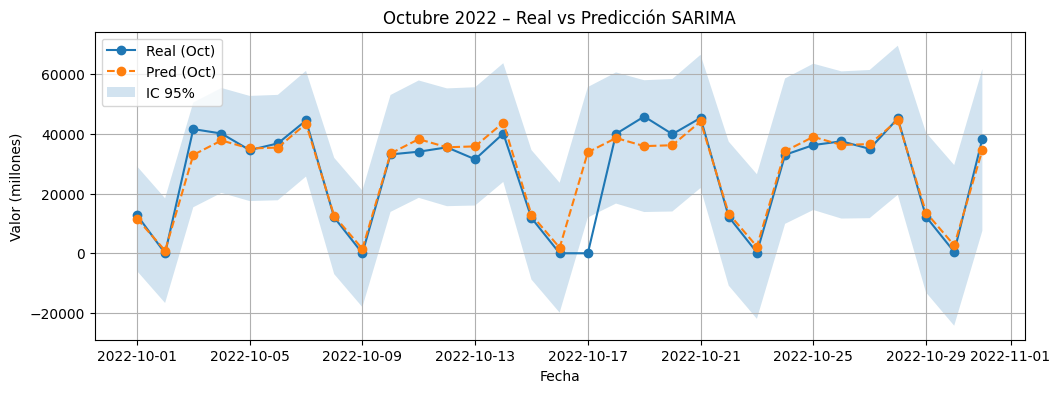

In [25]:
# %% Gráfico: Oct real vs predicción + IC
plt.figure(figsize=(12,4))
plt.plot(test_oct.index, y_true, marker='o', linestyle='-', label='Real (Oct)')
plt.plot(test_oct.index, y_pred, marker='o', linestyle='--', label='Pred (Oct)')
plt.fill_between(ci_oct.index, ci_oct['lower'], ci_oct['upper'], alpha=0.2, label='IC 95%')
plt.title(f"Octubre 2022 – Real vs Predicción SARIMA")
plt.xlabel("Fecha"); plt.ylabel("Valor (millones)"); plt.grid(True); plt.legend()
plt.show()

## 7. Pronóstico para noviembre 2022

Genera el pronóstico para noviembre 2022 (30 días) usando el modelo entrenado, y prepara el DataFrame con los resultados y sus intervalos de confianza.

In [18]:
# %% Pronóstico Noviembre 2022 (30 días)
# Reentrenar con train completo (jul–oct) puede ser discutible; seguimos con train (jul–sep) para mantener protocolo estricto.
# Sin embargo, muchas veces el pronóstico futuro se hace con todo lo disponible hasta el presente. Dejamos ambas opciones.

# Opción A (estricta al protocolo): usar el mismo modelo entrenado con jul–sep
steps_nov = 30  # 2022-11 tiene 30 días
fc_nov = res.get_forecast(steps=steps_nov)
pred_nov = fc_nov.predicted_mean
ci_nov = fc_nov.conf_int(alpha=0.05)
ci_nov.columns = ["lower", "upper"]

# Generar índice de fechas para noviembre 2022
nov_index = pd.date_range("2022-11-01", "2022-11-30", freq="D")
pred_nov.index = nov_index
ci_nov.index = nov_index

forecast_nov = pd.DataFrame({
    "fecha": pred_nov.index,
    "yhat": pred_nov.values,
    "yhat_lower": ci_nov["lower"].values,
    "yhat_upper": ci_nov["upper"].values
})

forecast_nov.head()

,fecha,yhat,yhat_lower,yhat_upper
0,2022-11-01,11623.449346,-5906.695415,29153.594108
1,2022-11-02,875.652600,-16654.885265,18406.190465
2,2022-11-03,32944.800830,15402.522173,50487.079487
3,2022-11-04,37786.891424,20216.620226,55357.162621
4,2022-11-05,35089.933650,17481.931978,52697.935322


## 8. Gráfico: histórico + forecast noviembre

Grafica la serie histórica (jul-oct) junto con el forecast de noviembre y sus intervalos de confianza.

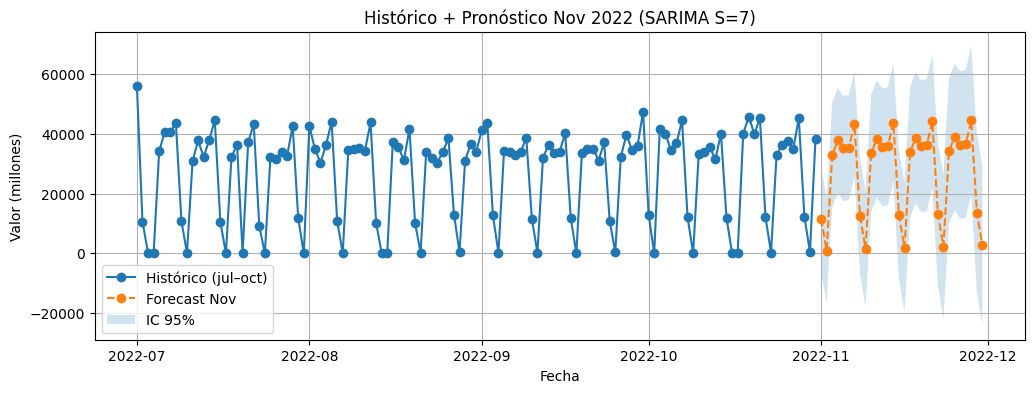

In [19]:
# %% Gráfico: Historia (jul–oct) + Forecast nov 2022
plt.figure(figsize=(12,4))
plt.plot(df.index, df[y_col], marker='o', linestyle='-', label='Histórico (jul–oct)')
plt.plot(forecast_nov["fecha"], forecast_nov["yhat"], marker='o', linestyle='--', label='Forecast Nov')
plt.fill_between(forecast_nov["fecha"], forecast_nov["yhat_lower"], forecast_nov["yhat_upper"], alpha=0.2, label='IC 95%')
plt.title("Histórico + Pronóstico Nov 2022 (SARIMA S=7)")
plt.xlabel("Fecha"); plt.ylabel("Valor (millones)"); plt.grid(True); plt.legend()
plt.show()

## 9. Guardar resultados y exportables

Guarda métricas, predicciones de octubre, forecast de noviembre y un archivo Excel con todos los resultados en la carpeta outputs_p3.

In [23]:
# Punto 3 – Generar ENTREGABLE_Punto3.xlsx con métricas y forecast (SARIMA)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from pathlib import Path

# 1) Cargar datos crudos
raw_path = Path("../data/clean/Punto3.SerieUsodeldinero_clean.csv")
df = pd.read_csv(raw_path)
df["fecha"] = pd.to_datetime(df["fecha"])
df = df.sort_values("fecha").reset_index(drop=True)

# 2) Relleno de rango completo
full_range = pd.date_range(df["fecha"].min(), df["fecha"].max(), freq="D")
df = df.set_index("fecha").reindex(full_range).rename_axis("fecha").reset_index()

# 3) Marcar domingos y festivos observados
festivos = {
    pd.Timestamp("2022-07-04"),
    pd.Timestamp("2022-07-20"),
    pd.Timestamp("2022-08-15"),
    pd.Timestamp("2022-10-17"),
}
df["dow"] = df["fecha"].dt.weekday     # 0=Lun ... 6=Dom
df["is_sunday"] = df["dow"] == 6
df["is_holiday"] = df["fecha"].isin(festivos)

# 4) Llenado de NaN
serie_col = "valor_total_millones"
mask_nf = df[serie_col].isna()
mask_zero = mask_nf & (df["is_sunday"] | df["is_holiday"])
df.loc[mask_zero, serie_col] = 0.0
# Interpolar restantes
mask_inter = df[serie_col].isna()
if mask_inter.any():
    df[serie_col] = df[serie_col].interpolate(method="linear", limit_direction="both")

# 5) Split
df = df.set_index("fecha")
y_col = "valor_total_millones"
train = df.loc["2022-07-01":"2022-09-30", [y_col]].copy()
test_oct = df.loc["2022-10-01":"2022-10-31", [y_col]].copy()

# 6) Grid SARIMA S=7 (igual al del notebook)
best = {"aic": np.inf, "order": None, "seasonal_order": None, "res": None}
y_train = train[y_col]

for p in range(0,3):
    for d in range(0,2):
        for q in range(0,3):
            for P in range(0,2):
                for D in range(0,2):
                    for Q in range(0,2):
                        try:
                            model = SARIMAX(
                                y_train,
                                order=(p,d,q),
                                seasonal_order=(P,D,Q,7),
                                enforce_stationarity=False,
                                enforce_invertibility=False
                            )
                            res = model.fit(disp=False)
                            aic = res.aic
                            if aic < best["aic"]:
                                best.update({"aic": aic, "order": (p,d,q), "seasonal_order": (P,D,Q,7), "res": res})
                        except Exception as e:
                            continue

res = best["res"]
order, seasonal_order = best["order"], best["seasonal_order"]

# 7) Predicción Octubre y métricas robustas
steps = len(test_oct)
fc_oct = res.get_forecast(steps=steps)
pred_oct = fc_oct.predicted_mean
ci_oct = fc_oct.conf_int(alpha=0.05)
ci_oct.columns = ["lower", "upper"]
pred_oct.index = test_oct.index
ci_oct.index = test_oct.index

y_true = test_oct[y_col].astype(float).values
y_pred = pred_oct.astype(float).values
idx = test_oct.index
eps = 1e-8

is_sunday = (idx.weekday == 6)
is_zero   = (y_true <= 1e-6)
mask_habiles = ~is_sunday & ~is_zero

def mape_masked(y, yhat, mask):
    y_m, yhat_m = y[mask], yhat[mask]
    return 100.0 * np.mean(np.abs(y_m - yhat_m) / np.maximum(eps, np.abs(y_m)))

def smape(y, yhat):
    return 100.0 * np.mean(2.0*np.abs(yhat - y) / (np.abs(y) + np.abs(yhat) + eps))

def wmape(y, yhat):
    return 100.0 * np.sum(np.abs(y - yhat)) / (np.sum(np.abs(y)) + eps)

mape_oct_habiles = mape_masked(y_true, y_pred, mask_habiles)
smape_oct_all    = smape(y_true, y_pred)
wmape_oct_all    = wmape(y_true, y_pred)

# 8) Error por día de la semana (octubre)
oct_df = test_oct.copy()
oct_df["pred"] = y_pred
oct_df["dow_name"]  = oct_df.index.day_name()
oct_df["ape"] = np.abs(oct_df[y_col]-oct_df["pred"]) / np.maximum(1e-8, np.abs(oct_df[y_col]))
order_dow = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
by_dow = oct_df.groupby("dow_name")["ape"].mean().reindex(order_dow) * 100.0

# 9) Reentrenar con jul–oct y pronóstico Noviembre (30 días)
y_all = df.loc["2022-07-01":"2022-10-31", y_col]
model_all = SARIMAX(y_all, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
res_all = model_all.fit(disp=False)
fc_nov_all = res_all.get_forecast(steps=30)
pred_nov_all = fc_nov_all.predicted_mean
ci_nov_all = fc_nov_all.conf_int(alpha=0.05)
ci_nov_all.columns = ["lower", "upper"]

nov_index = pd.date_range("2022-11-01","2022-11-30",freq="D")
pred_nov_all.index = nov_index
ci_nov_all.index   = nov_index
forecast_nov_all = pd.DataFrame({
    "fecha": nov_index,
    "yhat": pred_nov_all.values,
    "yhat_lower": np.clip(ci_nov_all["lower"].values, a_min=0, a_max=None),
    "yhat_upper": np.clip(ci_nov_all["upper"].values, a_min=0, a_max=None),
})
forecast_nov_all["yhat_clipped_0"] = np.clip(forecast_nov_all["yhat"], a_min=0, a_max=None)

# 10) Tablas para exportar
metrics = pd.DataFrame([{
    "modelo": "SARIMA",
    "order": str(order),
    "seasonal_order": str(seasonal_order),
    "AIC_train": best["aic"],
    "MAPE_oct_habiles": mape_oct_habiles,
    "sMAPE_oct_todos": smape_oct_all,
    "WMAPE_oct_todos": wmape_oct_all
}])

pred_oct_df = pd.DataFrame({
    "fecha": idx,
    "real_oct": y_true,
    "pred_oct": y_pred,
    "lower_95": ci_oct["lower"].values,
    "upper_95": ci_oct["upper"].values
})

by_dow_df = by_dow.reset_index()
by_dow_df.columns = ["dia_semana","APE_promedio_%"]

# 11) Exportar Excel
out_xlsx = Path("./output_p3/ENTREGABLE_Punto3.xlsx")
with pd.ExcelWriter(out_xlsx, engine="xlsxwriter") as writer:
    metrics.to_excel(writer, sheet_name="Resumen", index=False)
    pred_oct_df.to_excel(writer, sheet_name="Pred_Oct", index=False)
    by_dow_df.to_excel(writer, sheet_name="Error_por_DOW", index=False)
    forecast_nov_all.to_excel(writer, sheet_name="Forecast_Nov", index=False)

out_xlsx, metrics, by_dow_df.head(), forecast_nov_all.head()


(PosixPath('output_p3/ENTREGABLE_Punto3.xlsx'),
    modelo      order seasonal_order    AIC_train  MAPE_oct_habiles  \
 0  SARIMA  (1, 1, 2)   (0, 1, 1, 7)  1540.667058          7.232065   
 
    sMAPE_oct_todos  WMAPE_oct_todos  
 0        41.407009        12.218731  ,
   dia_semana  APE_promedio_%
 0     Monday    6.763663e+13
 1    Tuesday    7.295610e+00
 2  Wednesday    6.631937e+00
 3   Thursday    7.845653e+00
 4     Friday    3.896160e+00,
        fecha          yhat    yhat_lower    yhat_upper  yhat_clipped_0
 0 2022-11-01  37489.812720  19306.392628  55673.232812    37489.812720
 1 2022-11-02  38970.863315  20787.052693  57154.673937    38970.863315
 2 2022-11-03  36569.864198  18377.634630  54762.093766    36569.864198
 3 2022-11-04  44892.048078  26680.663544  63103.432613    44892.048078
 4 2022-11-05  13110.402467      0.000000  31346.699728    13110.402467)